In [3]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

from pykat import finesse                 
from pykat.commands import *               
from pykat.optics.maps import * 
from pykat.parallel import parakat

%config InlineBackend.figure_format='svg'
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

## Content:
This notebook is about using random maps with astigmatism added and rotation applied to the four test mirrors and calculate the resulting contrast defects. 

In [2]:
HG33base = finesse.kat()         
HG33base.verbose = False
HG33base.parse( """
l laser 100 0 n0          
s s0 1 n0 n1                        
maxtem 8

mod EOM1 $fEOM 0.3 1 pm 0 n1 n2
s s1 0 n2 nBSb

## Central beam splitter ##
bs1 BS 0.5 3.75e-05 0 45 nBSb nBSy nBSx nBSd 

#higher order mode HG33
tem laser 0 0 0.0 0.0
tem laser 3 3 1.0 0.0

## X arm ##                   
s slX 6.9 nBSx nX1
m1 ITMX 0.014 3.75e-05 0 nX1 nX2
s sLX 3994.4692 nX2 nX3 
m1 ETMX 5e-06 3.75e-05 0 nX3 dump
cav cavityX ITMX nX2 ETMX nX3

## Y arm ##
s slY 7.1 nBSy nY1
m1 ITMY 0.014 3.75e-05 0 nY1 nY2
s sLY 3994.4692 nY2 nY3 
m1 ETMY 5e-06 3.75e-05 0 nY3 dump
cav cavityY ITMY nY2 ETMY nY3

# 1ppm again
attr ETMX Rc 2679.93
attr ETMY Rc 2679.93
attr ITMX Rc -2679.93
attr ITMY Rc -2679.93

const fEOM 10M

"""
)      

In [21]:
pk=parakat()
for i in range(0,53,4):
    HG33kat = HG33base.deepcopy() 
    HG33kat.ETMY.phi = 0 
    HG33kat.ETMX.phi = 0
    HG33kat.ITMY.phi = -3.75425
    HG33kat.ITMX.phi = -3.75425
    HG33kat.BS.phi = 63.61875 
    
    amp = 400 # The amplitude A22 of Zernike 22 content
    s = 1/2679.93
    deltas = 0.08889e-6*amp # Convert between A22 to the change of curvature s
    HG33kat.ETMY.Rcx = 1/(s+deltas) # Apply the change of curvature to the ETMs and ITMs
    HG33kat.ETMY.Rcy = 1/(s-deltas) # Note that the absolute value of Rcx should be decreasing and Rcy should be increasing
    HG33kat.ETMX.Rcx = 1/(s+deltas)
    HG33kat.ETMX.Rcy = 1/(s-deltas)

    HG33kat.ITMY.Rcx = -1/(s+deltas)
    HG33kat.ITMY.Rcy = -1/(s-deltas)
    HG33kat.ITMX.Rcx = -1/(s+deltas)
    HG33kat.ITMX.Rcy = -1/(s-deltas)

    HG33kat.parse(f"""
    map ETMY randommaps/{amp}nmCDrandommap{i}.txt
    map ETMX randommaps/{amp}nmCDrandommap{i+1}.txt
    map ITMY randommaps/{amp}nmCDrandommap{i+2}.txt
    map ITMX randommaps/{amp}nmCDrandommap{i+3}.txt

    # CARM error signal and lock for ITMs tuning
    const fEOM 10M
    pd1 CARM $fEOM 0 nBSb
    set CARMerr CARM re
    lock CARMlock $CARMerr 1e-3 1n
    func ITMphi = $CARMlock/2
    put ITMY phi $ITMphi
    put ITMX phi $ITMphi

    # DARM error signal and lock for ETMs tunings
    pd1 DARM $fEOM 90 nBSd
    set DARMerr DARM re
    lock DARMlock $DARMerr -1e-1 1n
    func ETMXphi=$DARMlock/2
    func ETMYphi=(-1)*$ETMXphi
    put ETMY phi $ETMYphi
    put ETMX phi $ETMXphi

    pd darkport nBSd
    pd brightport nBSb
    pd power nX3

    """)
    HG33kat.noxaxis = True
    pk.run(HG33kat)
out = pk.getResults()

contrastHG = []
for i in range(14):
    contrast=out[i]['darkport']/out[i]['brightport']
    contrastHG.append(contrast)

pd.Series(contrastHG).to_pickle(f'pkl/CDHG33{amp}nmrotated.pkl')

Parallel jobs: 100%|##########################################################|

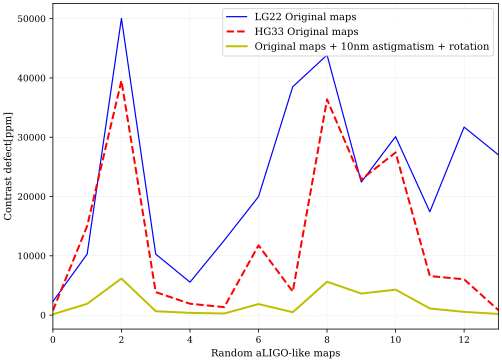

In [6]:
CDdf = pd.read_pickle('pkl/contrastDefects.pkl')
CDrotated10nm = pd.read_pickle('pkl/CDHG3310nmrotated.pkl').values
CDrotated0nm = pd.read_pickle('pkl/CDHG330nmrotated.pkl').values

fig,ax =plt.subplots(figsize=(8,6))
ax.plot(CDdf['LG22']['maps and lock']*1e6,'b',label='LG22 Original maps')
ax.plot(CDdf['HG33']['maps and lock']*1e6,'r--',label='HG33 Original maps',linewidth=2)
ax.plot(CDrotated10nm*1e6,'y',label='Original maps + 10nm astigmatism + rotation',linewidth=2)


ax.set_xlabel("Random aLIGO-like maps")
ax.set_ylabel("Contrast defect[ppm]")
ax.legend(loc='best')
plt.show()
fig.savefig('../cd10nm.pdf')
# The contrast defect with astigmatism added
# the contrast defect has been reduced a lot

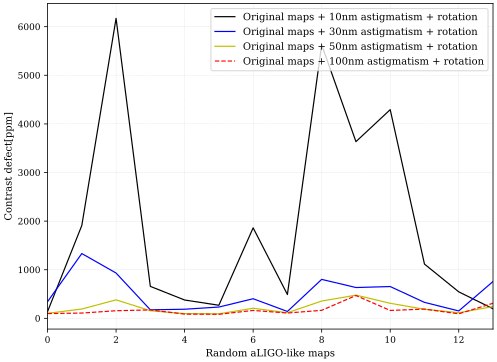

In [10]:
CDrotated10nm = pd.read_pickle('pkl/CDHG3310nmrotated.pkl').values
CDrotated30nm = pd.read_pickle('pkl/CDHG3330nmrotated.pkl').values
CDrotated50nm = pd.read_pickle('pkl/CDHG3350nmrotated.pkl').values
CDrotated100nm = pd.read_pickle('pkl/CDHG33100nmrotated.pkl').values

fig,ax =plt.subplots(figsize=(8,6))

ax.plot(CDrotated10nm*1e6,'k',label='Original maps + 10nm astigmatism + rotation')
ax.plot(CDrotated30nm*1e6,'b',label='Original maps + 30nm astigmatism + rotation')
ax.plot(CDrotated50nm*1e6,'y',label='Original maps + 50nm astigmatism + rotation')
ax.plot(CDrotated100nm*1e6,'r--',label='Original maps + 100nm astigmatism + rotation')

ax.set_xlabel("Random aLIGO-like maps")
ax.set_ylabel("Contrast defect[ppm]")
ax.legend(loc='upper right')
plt.show()
fig.savefig('../cdincreasing.pdf')
# The contrase defect with more and more astigmatism added

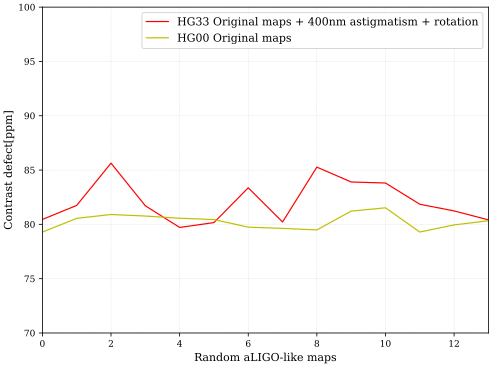

In [5]:
CDrotated400nm = pd.read_pickle('pkl/CDHG33400nmrotated.pkl').values
# CDrotated500nm = pd.read_pickle('pkl/CDHG33500nmrotated.pkl').values
CDdf = pd.read_pickle('pkl/contrastDefects.pkl')

fig,ax =plt.subplots(figsize=(8,6))

ax.plot(CDrotated400nm*1e6,'r',label='HG33 Original maps + 400nm astigmatism + rotation')
ax.plot(CDdf['HG00']['maps and lock']*1e6,'y',label='HG00 Original maps')
# ax.plot(CDrotated500nm*1e6,'r',label='HG33 Original maps + 500nm astigmatism + rotation')

ax.set_xlabel("Random aLIGO-like maps")
ax.set_ylabel("Contrast defect[ppm]")
ax.set_ylim(70,100)
ax.legend(loc='upper right')
plt.show()
fig.savefig('../cd400.pdf')
# The contrast defect of HG33 mode with 400nm of astigmatism added